# Exploring He Initialization in Deep Neural Networks

**Author:** Alex Marzban
**Institution:** Boston University  
**Course:** GRS MA 752 


## Purpose of the Project

This Jupyter Notebook is dedicated to exploring the effects of He initialization on the training dynamics of deep neural networks. He initialization, designed specifically for layers with ReLU activation functions, aims to maintain the variance of activations throughout the network, which is crucial for the efficient training of deep models.

The goals of this project are to:
1. Understand the theoretical foundation of He initialization and how it compares to other popular initialization methods.
2. Implement He initialization in various neural network architectures and observe its impact on the learning process.
3. Analyze how the weights evolve during training with He initialization and assess its influence on the speed of convergence, final model accuracy, and training stability.
4. Evaluate the performance of networks using He initialization using ReLU and the defined PReLU activation function from the paper.
5. Compare the effects of ReLU and its adaptations as suggested in the original He initialization paper, providing a comprehensive view of how activation functions interact with this initialization strategy.

By conducting these experiments, this notebook will provide insights into whether He initialization should be the default choice for training deep neural networks with ReLU activations and under what conditions it most effectively improves model training.

In [14]:
#imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Detailed Summary of "Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification"

**Authors:** Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun  
**Affiliation:** Microsoft Research  
**Publication Year:** 2015  

#### Introduction
The paper introduces two major contributions to the deep learning domain: the Parametric Rectified Linear Unit (PReLU) and a novel weight initialization technique, now widely known as He initialization. These innovations are geared towards improving the training dynamics of deep neural networks, particularly those using rectified activation units, enabling the training of much deeper networks than was previously feasible.

#### Parametric Rectified Linear Unit (PReLU)
PReLU is proposed as an enhancement to the conventional ReLU by introducing a learnable parameter that modifies the activation function's behavior for negative inputs. This allows the network to adapt activation dynamics during training, which can lead to improved accuracy without substantial increase in computational cost.

- **Definition and Formula**: The PReLU function is defined as follows:
  $$
  f(y_i) = 
  \begin{cases} 
  y_i & \text{if } y_i > 0 \\
  a_i y_i & \text{if } y_i \leq 0 
  \end{cases}
  $$
  Here, $y_i$ is the input to the activation function, and $a_i$ is a learnable parameter that adapts during training, offering a gradient to non-positive inputs that differs from zero.

- **Computational Implications**: The introduction of $a_i$ adds minimal computational overhead as it introduces only a small number of additional parameters (equal to the number of channels in the layer), and these parameters are updated through the standard backpropagation process using gradients derived from the chain rule.

#### He Initialization
This novel initialization approach addresses the specific needs of networks using rectified units by adjusting the variance of the initial weights to maintain the activation variances constant across layers, thus facilitating the training of very deep networks.

- **Motivation and Importance**: Correct initialization is crucial for deep networks to avoid vanishing and exploding gradients. The authors argue that the popular Xavier initialization does not suit networks with ReLU/PReLU activations because it assumes linear activations.

- **He Initialization Formula**: The initialization method is derived by analyzing the variance propagation through a network with ReLU activations. For a layer $l$ with $n_l$ inputs (fan-in), the weights are initialized from a Gaussian distribution with mean 0 and variance given by:
  $$
  \text{Var}(W_l) = \frac{2}{n_l}
  $$
  This formula ensures that the variance of the outputs of each layer remains constant across the network, preventing the gradients from vanishing or exploding during training.

### Theoretical Justification for He Initialization

The He initialization method is designed to address the specific challenges associated with training deep neural networks that use rectified linear units (ReLUs). The fundamental idea behind He initialization is to adjust the variance of the initial weights such that the variance of the outputs from each layer remains approximately constant throughout the network. This is critical to prevent the gradients from vanishing or exploding, particularly in deep networks.

#### Problem with Traditional Initialization Methods
Traditional initialization methods, such as the Xavier initialization, assume that the activation function is linear. However, this assumption does not hold for rectifier units, which are inherently non-linear due to their zeroing out of negative inputs. The Xavier method sets the weights with a variance that scales inversely with the sum of the number of inputs and outputs of the layer, which can lead to a suboptimal variance of outputs in layers using ReLU activations.

#### Derivation of He Initialization
The derivation of the He initialization method begins with the goal of keeping the variance of the outputs of each layer constant. For a layer $l$ with weights $W_l$, inputs $x_l$, and outputs $y_l = W_l x_l$ followed by a ReLU, the aim is to maintain the variance of $y_l$ consistent across layers.

Let's assume the weights $W_l$ are initialized from a Gaussian distribution with mean 0 and variance $\sigma^2$. For simplicity, biases are typically initialized to 0. The output $y_l$ before activation is computed as:

$$ y_l = W_l x_l $$

For ReLU activation, the output post-activation becomes $\max(0, y_l)$. We are interested in the variance of $y_l$ at initialization. Assuming $x_l$ elements are independent and also have zero mean, the variance of the output $y_l$ for each neuron before activation is:

$$ \text{Var}(y_l) = n_l \sigma^2 \text{Var}(x_l) $$

where $n_l$ is the number of inputs to the neuron (fan-in).

Since the ReLU outputs zero for half the inputs (assuming inputs are symmetrically distributed around zero), the variance of the ReLU output is halved compared to its input:

$$ \text{Var}(\max(0, y_l)) = \frac{1}{2} \text{Var}(y_l) = \frac{1}{2} n_l \sigma^2 \text{Var}(x_l) $$

To ensure the variance of the outputs remains constant across layers, we set $\text{Var}(\max(0, y_l))$ equal to $\text{Var}(x_l)$, which implies:

$$ \frac{1}{2} n_l \sigma^2 \text{Var}(x_l) = \text{Var}(x_l) $$

Solving for $\sigma^2$ gives:

$$ \sigma^2 = \frac{2}{n_l} $$

Thus, the initialization variance for the weights should be set to $\frac{2}{n_l}$, where $n_l$ is the number of inputs to the neurons in layer $l$. This initialization strategy directly addresses the non-linear properties of the ReLU function, ensuring that the signal neither vanishes nor explodes as it propagates through the network, facilitating stable and efficient training even for very deep architectures.

#### Experimental Validation
The authors applied their methods to a deep convolutional network model on the ImageNet 2012 dataset, achieving state-of-the-art results that surpassed human-level performance.

- **Results and Metrics**: The network utilizing PReLU and He initialization achieved a top-5 error rate of 4.94%, significantly improving over previous models and even exceeding the human-level benchmark of 5.1% error rate.

- **Weight Initialization Impact**: The paper provides a detailed analysis of how the He initialization impacts the training process, demonstrating faster convergence and improved model performance across various network architectures.

# Code

In [10]:
#data loading and preprocessing code
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

# Define transformations for the training data
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # randomly flip image horizontally
    transforms.RandomCrop(32, padding=4),  # Random crop with padding
    transforms.ToTensor(),  # convert the image to a tensor
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # normalize with mean and std per channel
])

# Define transformations for the test data (no data augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load the datasets with ImageFolder, applying the transformations
train_dataset = CIFAR10(root='./data', train=True, transform=train_transform, download=True)
test_dataset = CIFAR10(root='./data', train=False, transform=test_transform, download=True)

# DataLoader setup for both training and testing, typically use a larger batch size for training
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def build_cnn(num_conv_layers, num_filters, activation_fn):
    layers = []
    first_layer = nn.Conv2d(3, num_filters, kernel_size=3, padding=1)
    nn.init.kaiming_normal_(first_layer.weight, mode='fan_out', nonlinearity='leaky_relu')  # Assuming PReLU behaves similar to leaky ReLU
    layers.append(first_layer)

    # Check if activation function is PReLU, initialize accordingly
    if activation_fn == nn.PReLU:
        layers.append(activation_fn(num_parameters=1))  # num_parameters=1 makes the parameter learnable across channels
    else:
        layers.append(activation_fn())

    size = 32
    for i in range(1, num_conv_layers):
        conv_layer = nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1)
        nn.init.kaiming_normal_(conv_layer.weight, mode='fan_out', nonlinearity='leaky_relu')  # Use leaky_relu for initialization with PReLU, but making the paramerer learnable across channels is equivalent to PReLU
        layers.append(conv_layer)
        layers.append(nn.BatchNorm2d(num_filters))
        
        if activation_fn == nn.PReLU:
            layers.append(activation_fn(num_parameters=1))  
        else:
            layers.append(activation_fn())
        
        # Apply pooling only on every second convolutional layer
        if i % 2 == 0:  
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            size = size // 2

    layers.append(nn.Flatten())
    flat_features = num_filters * size * size
    final_layer = nn.Linear(flat_features, 10)
    nn.init.kaiming_normal_(final_layer.weight, mode='fan_out', nonlinearity='leaky_relu') 
    layers.append(final_layer)
    
    model = nn.Sequential(*layers)
    return model


In [44]:
def build_cnn_basic(num_conv_layers, num_filters, activation_fn):
    layers = []
    first_layer = nn.Conv2d(3, num_filters, kernel_size=3, padding=1)
    # Initialize weights with a normal distribution (mean=0, std=1)
    torch.nn.init.normal_(first_layer.weight, mean=0.0, std=1.0)
    layers.append(first_layer)

    if activation_fn == nn.PReLU:
        layers.append(activation_fn(num_parameters=1))
    else:
        layers.append(activation_fn())

    size = 32
    for i in range(1, num_conv_layers):
        conv_layer = nn.Conv2d(num_filters, num_filters, kernel_size=3, padding=1)
        # Use normal distribution for initialization
        torch.nn.init.normal_(conv_layer.weight, mean=0.0, std=1.0)
        layers.append(conv_layer)
        layers.append(nn.BatchNorm2d(num_filters))

        if activation_fn == nn.PReLU:
            layers.append(activation_fn(num_parameters=1))
        else:
            layers.append(activation_fn())

        if i % 2 == 0:
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            size = size // 2

    layers.append(nn.Flatten())
    flat_features = num_filters * size * size
    final_layer = nn.Linear(flat_features, 10)
    # Initialize the final layer using normal distribution
    torch.nn.init.normal_(final_layer.weight, mean=0.0, std=1.0)
    layers.append(final_layer)

    model = nn.Sequential(*layers)
    return model

In [20]:
#training function
def train_cnn(model, train_loader, test_loader, epochs=10, learning_rate=1e-3):
    # Use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Lists to store the performance metrics
    average_weights = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()  
        total_loss = 0
        total = 0
        
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(data)
            loss = criterion(outputs, targets)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * data.size(0)
            total += data.size(0)
        
        # Calculate average weights and loss
        avg_loss = total_loss / total
        avg_weight = np.mean([torch.mean(param.data).item() for param in model.parameters()])
        average_weights.append(avg_weight)

        # Evaluate the model
        model.eval()  
        correct = 0
        total = 0

        with torch.no_grad():
            for data, targets in test_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        test_accuracy = 100 * correct / total
        test_accuracies.append(test_accuracy)

        #print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    return average_weights, test_accuracies
 

In [22]:
#testing function
def automate_model_testing(num_layers_list, num_filters, activation_fn, train_loader=train_loader, test_loader=test_loader, epochs=10):
    results = []

    for num_layers in num_layers_list:
        # Build the CNN model
        model = build_cnn(num_conv_layers=num_layers, num_filters=num_filters, activation_fn=activation_fn)
        print(f"Training model with {num_layers} convolutional layers...")

        # Train the model and collect the metrics
        average_weights, test_accuracies = train_cnn(model, train_loader, test_loader, epochs=epochs)

        # Store results
        results.append({
            'num_layers': num_layers,
            'average_weights': average_weights,
            'test_accuracies': test_accuracies
        })

        print(f"Completed training for model with {num_layers} layers. Test accuracy: {test_accuracies[-1]:.2f}%")

    return results

In [45]:
#testing function
def automate_model_testing_basic(num_layers_list, num_filters, activation_fn, train_loader=train_loader, test_loader=test_loader, epochs=10):
    results = []

    for num_layers in num_layers_list:
        # Build the CNN model
        model = build_cnn_basic(num_conv_layers=num_layers, num_filters=num_filters, activation_fn=activation_fn)
        print(f"Training model with {num_layers} convolutional layers...")

        # Train the model and collect the metrics
        average_weights, test_accuracies = train_cnn(model, train_loader, test_loader, epochs=epochs)

        # Store results
        results.append({
            'num_layers': num_layers,
            'average_weights': average_weights,
            'test_accuracies': test_accuracies
        })

        print(f"Completed training for model with {num_layers} layers. Test accuracy: {test_accuracies[-1]:.2f}%")

    return results

In [37]:

def plot_results(model_results):
    # Plot all average weights on the same plot for comparison
    fig, ax = plt.subplots(figsize=(10, 6))
    for result in model_results:
        epochs = range(1, len(result['average_weights']) + 1)
        ax.plot(epochs, result['average_weights'], label=f"Layers: {result['num_layers']}")
    
    ax.set_title('Comparison of Average Weights')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Average Weight')
    ax.grid(True)
    ax.legend()
    plt.show()

    # Plot test accuracy over epochs for each model
    fig, ax = plt.subplots(figsize=(10, 6))
    for result in model_results:
        epochs = range(1, len(result['test_accuracies']) + 1)
        ax.plot(epochs, result['test_accuracies'], label=f"Layers: {result['num_layers']}")

    ax.set_title('Test Accuracy vs Epochs')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Test Accuracy (%)')
    ax.grid(True)
    ax.legend()
    plt.show()

In [32]:
#experiment implementation with relu and he initialization
# Define parameters for model testing
num_layers_list = [2,5,10,12]  # Different numbers of convolutional layers to test
num_filters = 32
activation_fn = nn.ReLU

# Run the automation function
model_results = automate_model_testing(num_layers_list, num_filters, activation_fn, train_loader, test_loader, epochs=10)

Training model with 2 convolutional layers...
Completed training for model with 2 layers. Test accuracy: 55.83%
Training model with 5 convolutional layers...
Completed training for model with 5 layers. Test accuracy: 69.78%
Training model with 10 convolutional layers...
Completed training for model with 10 layers. Test accuracy: 78.76%
Training model with 12 convolutional layers...
Completed training for model with 12 layers. Test accuracy: 79.03%


Results Using ReLU Activation Function


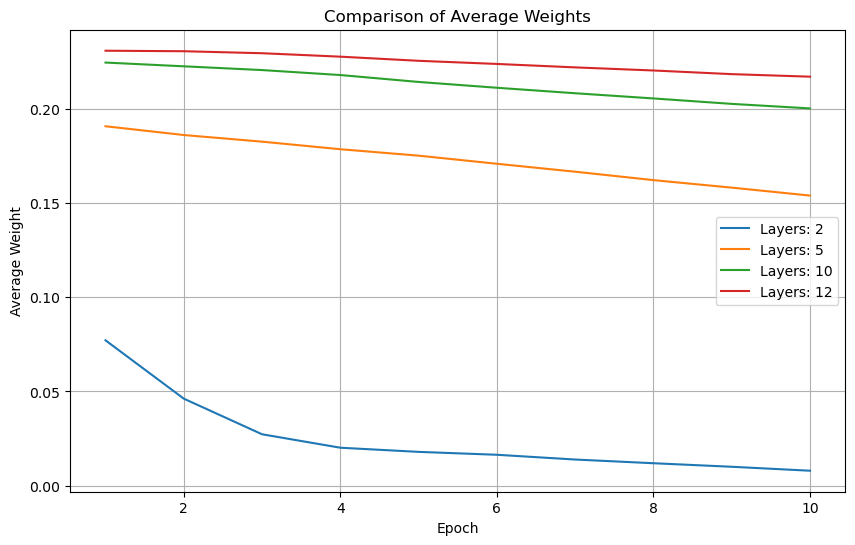

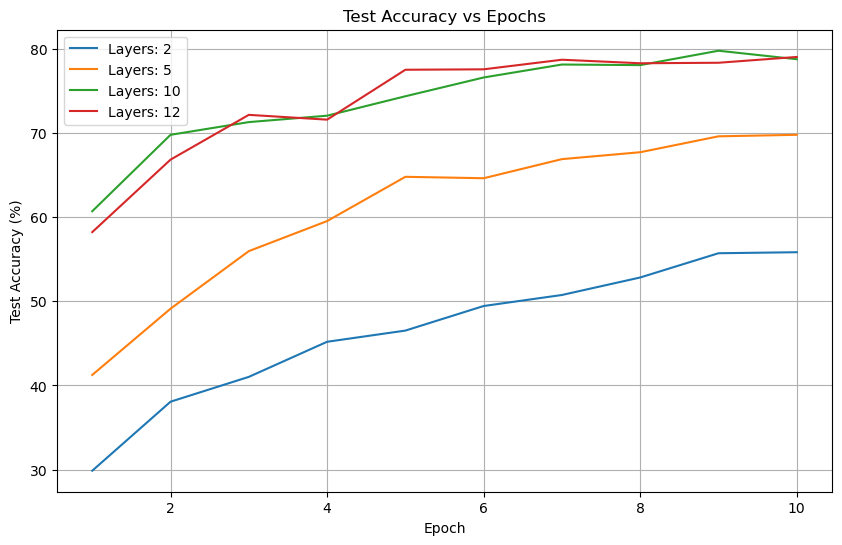

In [39]:
print("Results Using ReLU Activation Function")
plot_results(model_results)

In [41]:
#experiment implementation with prelu and he initialization
# Define parameters for model testing
num_layers_list = [2,5,10,12]  # Different numbers of convolutional layers to test
num_filters = 32
activation_fn = nn.PReLU

# Run the automation function
model_results = automate_model_testing(num_layers_list, num_filters, activation_fn, train_loader, test_loader, epochs=10)

Training model with 2 convolutional layers...
Completed training for model with 2 layers. Test accuracy: 57.03%
Training model with 5 convolutional layers...
Completed training for model with 5 layers. Test accuracy: 71.14%
Training model with 10 convolutional layers...
Completed training for model with 10 layers. Test accuracy: 79.14%
Training model with 12 convolutional layers...
Completed training for model with 12 layers. Test accuracy: 80.05%


Results Using PReLU Activation Function


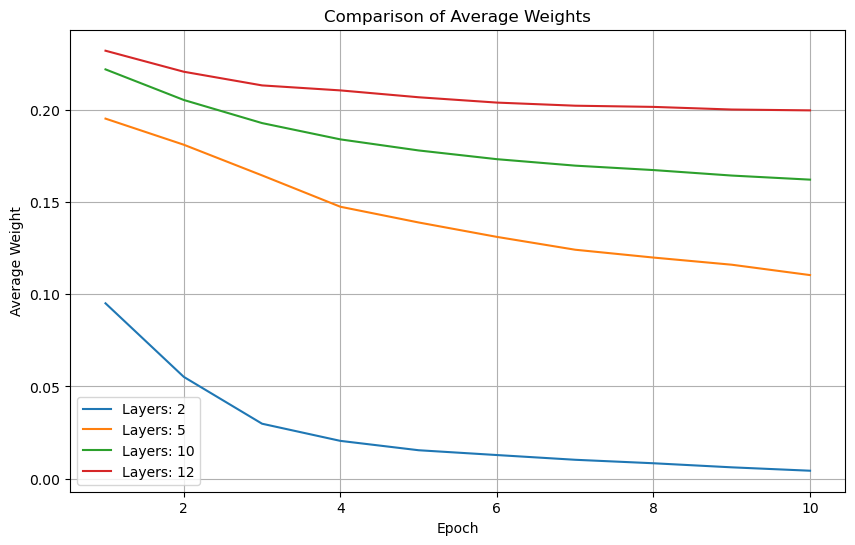

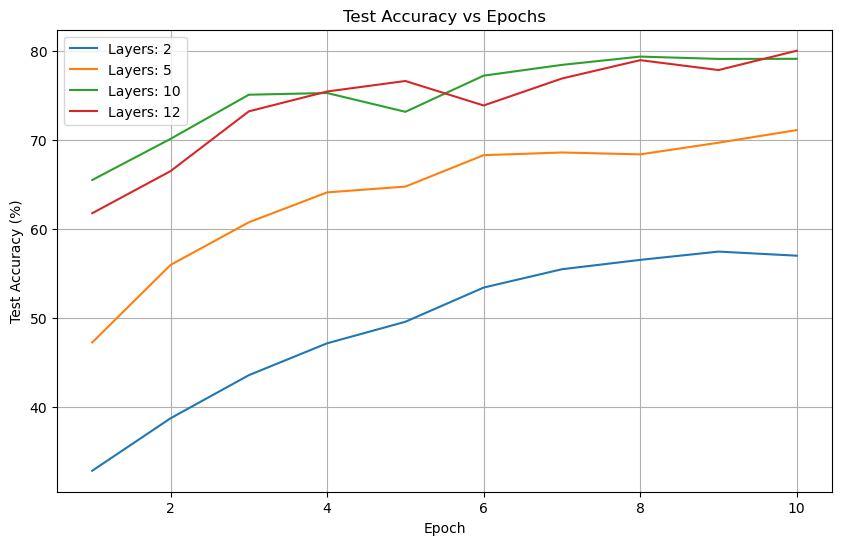

In [42]:
#results using prelu activation function and he initialization
print("Results Using PReLU Activation Function")
plot_results(model_results)

In [46]:
#experiment implementation with relu with initialization of weights using normal distribution
# Define parameters for model testing
num_layers_list = [2,5,10,12]  # Different numbers of convolutional layers to test
num_filters = 32
activation_fn = nn.ReLU

# Run the automation function
model_results_basic_relu = automate_model_testing_basic(num_layers_list, num_filters, activation_fn, train_loader, test_loader, epochs=10)

Training model with 2 convolutional layers...
Completed training for model with 2 layers. Test accuracy: 37.58%
Training model with 5 convolutional layers...
Completed training for model with 5 layers. Test accuracy: 47.94%
Training model with 10 convolutional layers...
Completed training for model with 10 layers. Test accuracy: 58.49%
Training model with 12 convolutional layers...
Completed training for model with 12 layers. Test accuracy: 58.63%


Results Using ReLU Activation Function with Normal Distribution Initialization


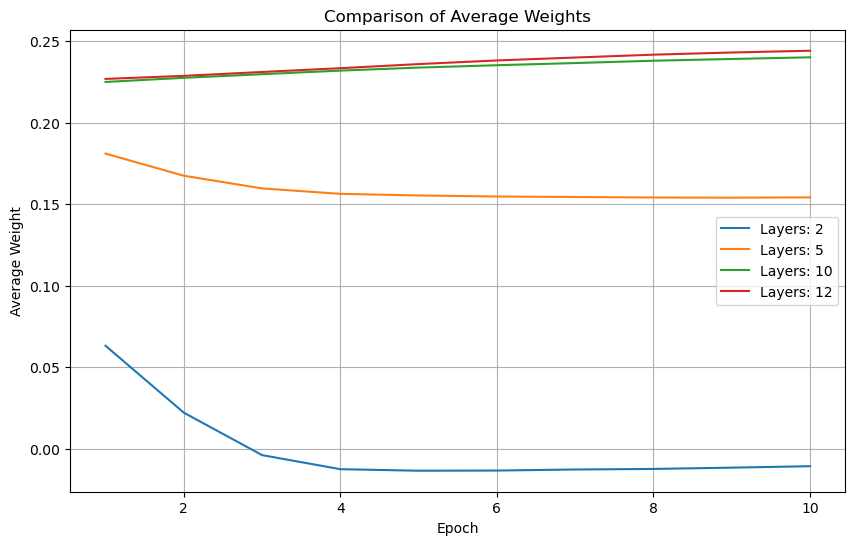

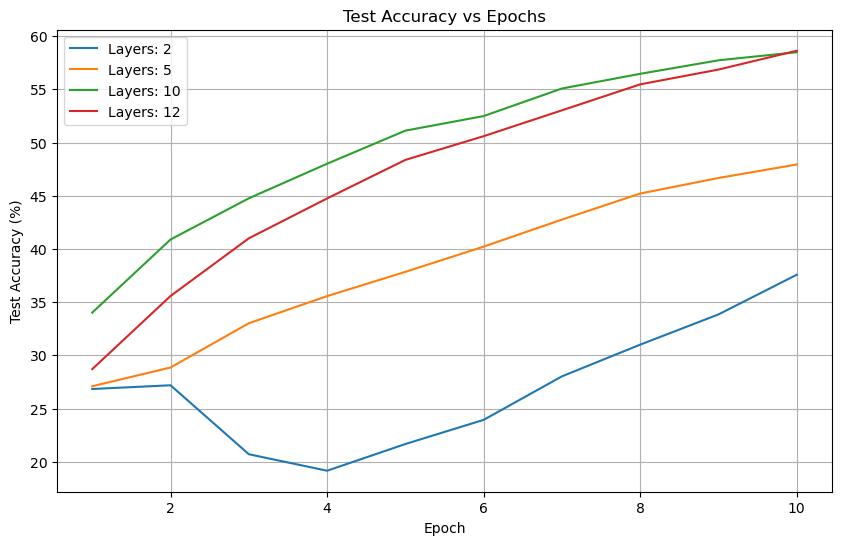

In [47]:
#results using prelu activation function
print("Results Using ReLU Activation Function with Normal Distribution Initialization")
plot_results(model_results_basic_relu)

In [48]:
#experiment implementation with prelu using normal distribution for initialization
# Define parameters for model testing
num_layers_list = [2,5,10,12]  # Different numbers of convolutional layers to test
num_filters = 32
activation_fn = nn.PReLU

# Run the automation function
model_results_basic_prelu = automate_model_testing_basic(num_layers_list, num_filters, activation_fn, train_loader, test_loader, epochs=10)

Training model with 2 convolutional layers...
Completed training for model with 2 layers. Test accuracy: 41.21%
Training model with 5 convolutional layers...
Completed training for model with 5 layers. Test accuracy: 51.03%
Training model with 10 convolutional layers...
Completed training for model with 10 layers. Test accuracy: 64.69%
Training model with 12 convolutional layers...
Completed training for model with 12 layers. Test accuracy: 64.28%


Results Using PReLU Activation Function with Normal Distribution Initialization


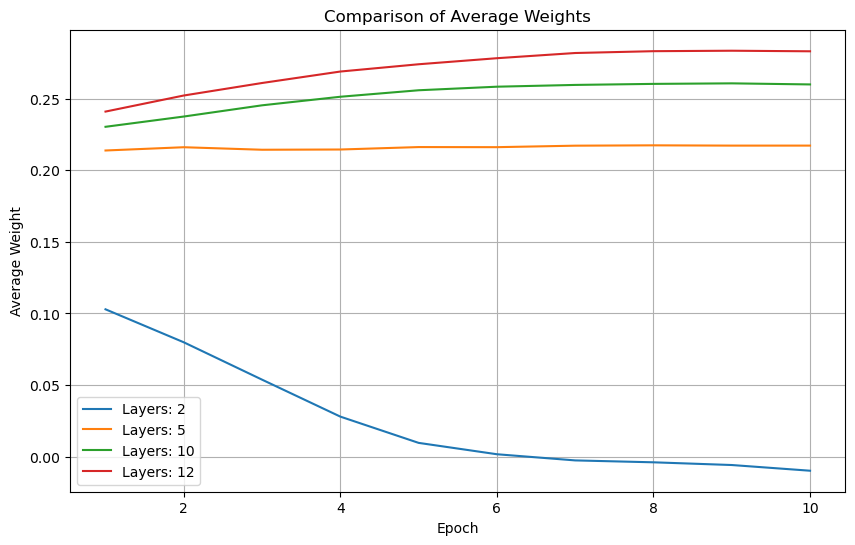

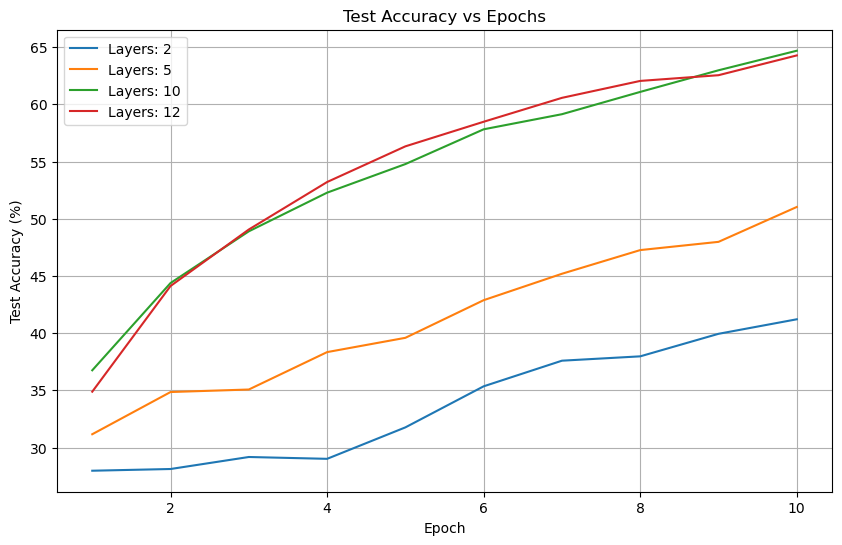

In [49]:
#results using prelu activation function wirh normal distribution initialization
print("Results Using PReLU Activation Function with Normal Distribution Initialization")
plot_results(model_results_basic_prelu)

# Code Explanation

### Data Loading and Preprocessing

The code defines transformations and loads the CIFAR-10 dataset for both training and testing. For the training data, it applies random horizontal flips and random cropping to augment the dataset, helping the model generalize better by providing varied examples during training. Both the training and testing sets are converted to tensors and normalized using predefined mean and standard deviation values for each channel (RGB), which aids in stabilizing the training process.

### Model Building

The `build_cnn` function constructs a convolutional neural network (CNN) with configurable parameters: the number of convolutional layers, the number of filters in each layer, and the choice of activation function, which can be a standard `ReLU` or a parametric `PReLU`. The model incorporates batch normalization after each convolutional layer to improve convergence rates, and employs pooling layers selectively to reduce spatial dimensions and computation needs. The model also uses He initialization of the weights (also called Kaiming initialization). The final output layer is a linear layer that maps the flattened features to the number of classes in CIFAR-10.

A variant of the model-building function, `build_cnn_basic_init`, uses a simpler weight initialization method where weights are initialized from a normal distribution with mean 0 and standard deviation 1. This allows for a control experiment to evaluate the impact of the He initialization.

### Training Function

The `train_cnn` function handles the training process of the model. It utilizes a GPU if available, sets up the loss function and optimizer (Adam), and manages both the forward and backward passes of the network. Training involves calculating the average weights and loss, and the function also evaluates the model on the test dataset to determine its accuracy, storing these metrics for analysis.

### Experiment Automation

The `automate_model_testing` function is used to systematically evaluate the CNN with different configurations, specifically varying the number of convolutional layers while keeping other parameters constant. It builds, trains, and collects performance metrics for each configuration, allowing for comparative analysis of how the depth of the model affects its performance.

A second function, `automate_model_testing_basic`, performs similar experiments using the `build_cnn_basic_init` function to assess models initialized with the normal distribution. This additional testing facilitates a direct comparison between the effects of basic and He (Kaiming) initializations under identical network configurations and activation functions.

### Visualization

The `plot_results` function visualizes the collected metrics, plotting the average weights and test accuracies over epochs for each model configuration. This visual representation helps in understanding the behavior of the model over time and the impact of different architectural choices.

### Experiments

The code conducts experiments using both `ReLU` and `PReLU` as activation functions to compare their effects on model performance. It tests models with increasing depths to see how the network complexity influences learning outcomes. Additionally, these experiments are replicated using both the He initialization and the simpler normal distribution initialization to evaluate and compare the impacts of different weight initialization strategies.

### Output

Finally, the results are printed and plotted to provide insights into the effectiveness of `PReLU` compared to `ReLU`, as well as the He initialization scheme, showcasing the potential benefits of using a learnable parameter in the activation function to adapt the model's behavior during training. The comparison between different initialization methods further enriches the analysis, providing valuable insights into how initialization impacts training dynamics and model performance.

# Results Summary and Analysis

1. **He Initialization with ReLU**:
   - For networks with 2 layers, average weights decrease sharply initially, indicating a significant adjustment of weights during the early phase of training.
   - As network depth increases to 5, 10, and 12 layers, the change in average weights during training is less pronounced, suggesting more stability in weight updates.
   - Test accuracy improves substantially with network depth, with a 12-layer network achieving over 75% accuracy, showing that deeper networks perform better on this dataset with He initialization.

2. **He Initialization with PReLU**:
   - The average weights remain relatively stable across epochs for all depths, with slight increases as the number of layers increases. This suggests that PReLU, combined with He initialization, maintains weight stability.
   - Test accuracy shows a similar trend to ReLU, but with a generally higher performance, particularly for networks with 10 and 12 layers, indicating that PReLU might be slightly more effective for deeper architectures in this setting.

3. **Normal Distribution Initialization with ReLU**:
   - The average weights show an initial sharp decline for 2-layer networks and then stabilize, similar to the He initialization pattern.
   - For deeper networks, the weights start relatively stable and do not exhibit large shifts, implying that ReLU is robust to initialization differences to some extent.
   - Test accuracy is significantly lower compared to He-initialized networks, especially notable in deeper networks with 10 and 12 layers. This illustrates the importance of sophisticated initialization methods for the performance of deep networks.

4. **Normal Distribution Initialization with PReLU**:
   - Average weights display a downward trend with the number of layers, unlike the He initialization where they remained more constant or increased slightly.
   - Test accuracy shows a clear positive correlation with the number of layers, but the performance is markedly lower than that with He initialization. The 12-layer network does not surpass 60% accuracy, highlighting the combined importance of advanced initialization and adaptable activation functions.

### General Observations
- Across all experiments, networks with more layers tend to have more stable average weights after the initial epochs of training.
- He initialization consistently outperforms normal distribution initialization, particularly in deeper networks, underlining its effectiveness in optimizing gradient flow in deep learning models.
- The combination of He initialization and PReLU appears to be the most effective, with the highest test accuracy among the configurations tested, suggesting that adaptable activation functions paired with appropriate weight initialization can yield better results.

### Conclusions and Future Work

The experimental outcomes indicate that sophisticated initialization methods like He initialization significantly improve the training and performance of deep convolutional neural networks. Additionally, using PReLU as an activation function provides an advantage over ReLU, particularly when coupled with He initialization, as seen in the superior test accuracy of these models.

However, these conclusions are drawn based on experiments conducted with the CIFAR-10 dataset and the specific network architectures employed. For a comprehensive understanding, future work should involve:

- Extending experimentation to additional datasets to generalize the findings.
- Applying these findings to different learning tasks, such as regression or sequence prediction, to assess their applicability across various domains.
- Experimenting with alternative neural network architectures, including variations in layer types, connections, and regularization methods.
- Utilizing more advanced computing resources, such as high-performance NVIDIA GPUs, could facilitate the training of even larger and more complex models to further explore the benefits of these initialization and activation techniques.

Overall, this project lays the groundwork for understanding how different initialization methods and activation functions affect deep neural network training, providing a platform for more in-depth future studies.

# Work cited
He, K., Zhang, X., Ren, S., & Sun, J. (2015). Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification. Proceedings of the IEEE International Conference on Computer Vision, 1026-1034. https://doi.org/10.1109/ICCV.2015.123

PyTorch. (n.d.). torch.nn.Conv2d. Retrieved April 20, 2024, from https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

PyTorch. (n.d.). torch.nn.PReLU. Retrieved April 20, 2024, from https://pytorch.org/docs/stable/generated/torch.nn.PReLU.html

PyTorch. (n.d.). torch.optim.Adam. Retrieved April 20, 2024, from https://pytorch.org/docs/stable/optim.html#torch.optim.Adam